### b728 - 15/08/2012 - DIAMET - Rain Band over Ireland

b728 was a DIAMET flight, when a heavy rain band above the north of Ireland was investigated. We are comparing groundbased NIMROD data with the liquid water content from the Johnson Williams instrument which is in the core dataset (Variable Name: LWC_JW_U).

Converting the NIMROD format into a well formatted netCDF that CIS can work with can be done with a script from the faampy module.

In [1]:
# faampy nimrod_to_nc metoffice-c-band-rain-radar_uk_20120815_1km-composite.dat.gz.tar

In [2]:
%matplotlib inline

import cis
import numpy as np
import os

ROOT_DATA_PATH = '/Users/watson-parris/Desktop/cis_workshop/data/b728'

os.chdir(ROOT_DATA_PATH)

### NIMROD data

In [3]:
nimrod = cis.read_data('metoffice-c-band-rain-radar_uk_20120815_1km-composite.nc', 'rain_intensity')

The dataset is quite large and we might run out of memory if we are not careful. Therefore we start subsetting the dataset to the area of interest which is Ireland and delete the nimrod variable.

In [4]:
ireland_bounds_lon = [-11,-5]
ireland_bounds_lat = [51, 56]
nimrod_ireland = nimrod.subset(x=ireland_bounds_lon, y=ireland_bounds_lat)

In [5]:
from cis.time_util import cis_standard_time_unit

# Rename timestamp to time, so that it gets matched with the aircraft coordinate later
nimrod_ireland.coord('timestamp').convert_units(cis_standard_time_unit)
nimrod_ireland.coord('timestamp').rename('time')

# To free up memory we delete the nimrod variable
del(nimrod)

There are some unreasonable high values in the rain intensity data. We flag everything using the 98 percentile.

In [6]:
_98per = np.percentile(nimrod_ireland.data, 98)
print(_98per)
nimrod_ireland.data.mask[nimrod_ireland.data > _98per] = True

5.59375


In [7]:
nimrod_ireland_mean = nimrod_ireland.collapsed('time', how='mean')[0]
# Mulitply by 24 to get total daily rain
nimrod_ireland_mean.data *= 24.

/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/iris/analysis/cartography.py:376: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


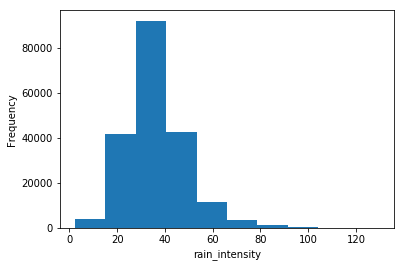

In [8]:
# Let's look at a histogramm
nimrod_ireland_mean.plot(how='histogram')

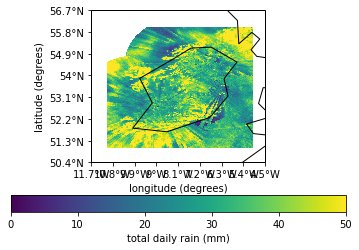

In [9]:
# We use the vmin and vmax keywords to clip the data,
# so that we see more structure in the heatmap
nimrod_ireland_mean.plot(label='total daily rain (mm)', vmin=0, vmax=50)

### Aircraft data

In [10]:
# Edit the faam core data to make it compatible with cis
# ./faam_edit.sh core_faam_20120815_v004_r1_b728_1hz.nc

Reading the edited core FAAM data with CIS.

In [11]:
ara_lwc = cis.read_data_list('core_faam_20120815_v004_r1_b728_1hz_edited.nc', 
                             'LWC_JW_U',
                             product='NCAR_NetCDF_RAF')

/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


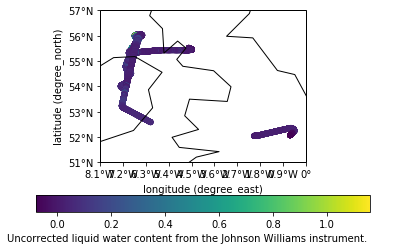

In [12]:
ara_lwc.plot()

Plot the data as time series.

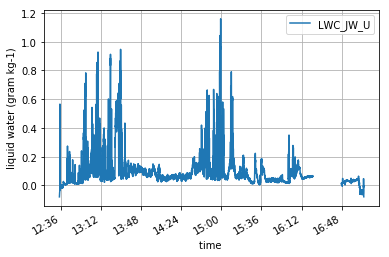

In [13]:
ax = ara_lwc.plot(xaxis='time', label='LWC_JW_U')
ax.set_ylabel('liquid water (gram kg-1)')
ax.grid(True)

### Comparing Aircraft and NIMROD data

We like to look at the one hour time from 14:30Z until 15:30Z.

In [14]:
from datetime import datetime
stime = datetime(2012,8,15,14,30)
etime = datetime(2012,8,15,15,30)

nimrod_ireland_subset = nimrod_ireland.subset(t=[stime, etime])

In [15]:
ara_lwc_col = ara_lwc.collocated_onto(nimrod_ireland_subset)

/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(0, 20)

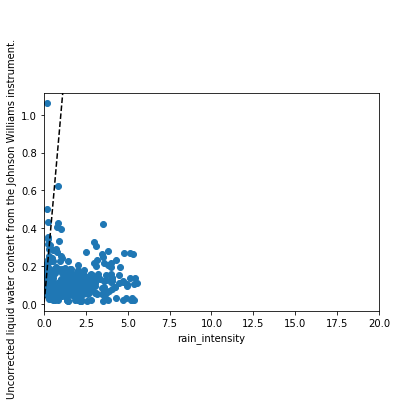

In [16]:
# TODO: Merge the two datasets and make a comparative scatter plot
# TODO: I struggle to do that, because the shapes do not match exatctly. 
from cis.plotting.plot import basic_plot
_, ax = basic_plot(ara_lwc_col[0], xaxis=nimrod_ireland_subset, how='comparativescatter')
ax.set_xlim(0, 20)

### Time series for Tullamore

CIS is using iris cubes to hold the data and therefore we can also use the interpolate method to extract a time series for a specific coordinate. 

In [17]:
import iris
# Tullamore coordinates
TullamoreCoord = [('latitude', 53.28),
                  ('longitude', -7.5)]
tullamore_rain = nimrod_ireland.interpolate(TullamoreCoord, iris.analysis.Linear())

matplotlib needs the timestamp to be in its own specific format.

In [18]:
import matplotlib as mpl
time_unit = tullamore_rain.coord('time').units
ts = [mpl.dates.date2num(time_unit.num2date(i)) for i in nimrod_ireland.coord('time').points]

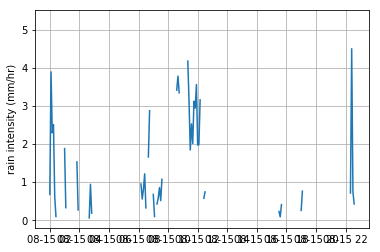

In [19]:
import matplotlib.pyplot as plt
plt.plot_date(ts, tullamore_rain.data, '-')
ax = plt.gca()
ax.grid(True)
ax.set_ylabel('rain intensity (mm/hr)')

### Catchment Hydrologie

The question we try to answer is: How much rain did the Barrow catchment area receive on the day b728 took place? We subset the rain intensity data from the RADAR over the catchment area.

Definition of catchment area:
A drainage basin or catchment area is any area of land where precipitation collects and drains off into a common outlet, such as into a river, bay, or other body of water.

The catchement spatial data are freely available from this website: http://gis.epa.ie/Envision

The data come as an ESRI shapefile, for which cartopy has a reader.

For the example we only one catchment (Barrow), because the subsetting over an irregular shape is very time consuming.

0: Lough Neagh & Lower Bann
1: Newry, Fane, Glyde and Dee
2: Boyne
3: Nanny-Delvin
4: Liffey and Dublin Bay
5: Ovoca-Vartry
6: Owenavorragh
7: Slaney & Wexford Harbour
8: Ballyteigue-Bannow
9: Barrow
10: Nore
11: Suir
12: Colligan-Mahon
13: Blackwater (Munster)
14: Lee, Cork Harbour and Youghal Bay
15: Bandon-Ilen
16: Dunmanus-Bantry-Kenmare
17: Laune-Maine-Dingle Bay
18: Tralee Bay-Feale
19: Shannon Estuary South
20: Lower Shannon
21: Lower Shannon
22: Lower Shannon
23: Lower Shannon
24: Upper Shannon
25: Upper Shannon
26: Upper Shannon
27: Upper Shannon
28: Upper Shannon
29: Upper Shannon
30: Upper Shannon
31: Shannon Estuary North
32: Mal Bay
33: Galway Bay South East
34: Corrib
35: Galway Bay North
36: Erriff-Clew Bay
37: Blacksod-Broadhaven
38: Moy & Killala Bay
39: Sligo Bay & Drowse
40: Erne


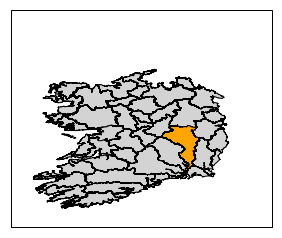

In [20]:
# Import the shapefile reader
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt

reader = shpreader.Reader('./catchments/WFD_Catchments.shp')

# Get the records
catchments = reader.records()

# create a map
ax = plt.axes(projection=ccrs.PlateCarree())
# 
ax.set_extent([ireland_bounds_lon[0],
               ireland_bounds_lon[1],
               ireland_bounds_lat[0],
               ireland_bounds_lat[1]])

# And let's have a quick look what is in there and plot the catchments
for i, c in enumerate(catchments):
    print('%i: %s' % (i, c.attributes['Name']))
    # Make the Barrow catchment orange and all the others grey
    if c.attributes['Name'].lower() == 'barrow':
        fc = 'orange'
    else:
        fc = 'lightgrey'
    ax.add_geometries([c.geometry], ccrs.PlateCarree(), facecolor=fc, edgecolor='black')

In [21]:
# We like to look closer at the Barrow catchment
catchments = reader.records()
for i, c in enumerate(catchments):
    if c.attributes['Name'].strip().lower() == 'barrow':
        barrow_catchment = c

# We need to collapse the timestamp first
nimrod_ireland_mean = nimrod_ireland.collapsed('time', how='mean')[0]

# get the size of the catchment area
area_km2 = barrow_catchment.attributes['Area_km2']
print("Area: {}".format(area_km2))

/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/iris/analysis/cartography.py:376: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


Area: 3015.70373466


CIS allows subsetting with an arbitrary geometry provided in WKT format (well-known-text).

In [22]:
# We could just do this, but it's a very detailed geometry containing hundreds of polygons
# nimrod_barrow = nimrod_ireland_mean.subset(shape=barrow_catchment.geometry)

# Instead we can simplify the geometry by specifying a tolerance (in degrees). This makes
#  the resulting subset *much* faster. Play with the tolerance to get the right balance 
#  between speed and accuracy.
nimrod_barrow = nimrod_ireland_mean.subset(shape=barrow_catchment.geometry.simplify(0.1))

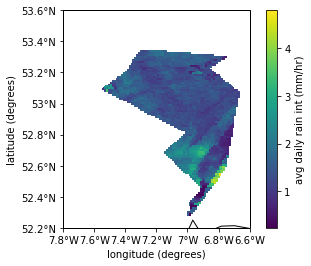

In [23]:
nimrod_barrow.plot(label='avg daily rain int (mm/hr)')

In [24]:
print('    Hourly mean rain intensity (mm/hr): %6.2f' % (nimrod_barrow.data.mean()))
print('                    Daily sum (mm/day): %6.2f' % (nimrod_barrow.data.mean()*24.))
print('Total water for whole catchment (m**3): %i' % (nimrod_barrow.data.mean()*24.*area_km2*1000.))

    Hourly mean rain intensity (mm/hr):   1.48
                    Daily sum (mm/day):  35.59
Total water for whole catchment (m**3): 107328968
